## Imports

In [116]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from tensorflow.keras import models, layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from tensorflow import keras
from keras.callbacks import EarlyStopping

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.utils import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV

import sys

sys.path.insert(0, '../../ml_logic')

from preprocessor import *
from data import *

## Data Load, Clean & Preprocess

In [121]:
# Import data from CSV
wingman_data = pd.read_csv("../../raw_data/trimmed_data/wingman_data_v6.csv")

In [122]:
target_columns_v1 = ['phase_no', 'eventsoe_no']
target_columns_v2 = ['category_no', 'subcategory_no', 'section_no', 'subsection_no', 'modifier_no']
target_columns_v3 = ['category_no']
target_columns_v4 = ['eventsoe_no']
target_columns_v5 = ['subcategory_no']
target_columns_v6 = ['subcategory_no']

In [124]:
# Clean
wingman_data_clean = clean_data(wingman_data)

# wingman_data_clean = wingman_data_clean[[
#     'flight_hours_mean',
#     'afm_hrs',
#     'dprt_time',
#     'cert_max_gr_wt',
#     'power_units',
#     'total_seats',
#     'fixed_retractable',
#     'pc_profession',
#     'type_last_insp',
#     'carb_fuel_injection',
#     'second_pilot',
#     'dest_apt_id',
#     'eng_mfgr',
#     'flt_plan_filed',
#     'acft_make',
#     'subcategory_no',
#     ]]

# Preprocess
wingman_data_proc = preprocess_features(wingman_data_clean, target_columns_v6)

/home/aaron/code/AaronDV17/wingman-project/notebooks/AaronDV17/../../ml_logic/encoders.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wingman_data_enc[''] = np.where(wingman_data_enc['type_fly'].isin(top_9_categories), wingman_data_enc['type_fly'], 'Other')
/home/aaron/code/AaronDV17/wingman-project/notebooks/AaronDV17/../../ml_logic/encoders.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_mfgr['eng_mfgr'] = eng_mfgr['eng_mfgr'].str.upper()
/home/aaron/code/AaronDV17/wingman-project/notebooks

In [125]:
X = wingman_data_proc.drop(columns=["subcategory_no"])
y = wingman_data_proc["subcategory_no"]

## Model (DTC)

### Train test split

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

### Process

In [127]:
# Most Frequent Class Accuracy

freq = max(y.value_counts()/len(y))
print("Most Frequent Class Accuracy: %.2f%%" % (freq * 100.0))

Most Frequent Class Accuracy: 52.94%


In [128]:
# Baseline Accuracy

dtc = DecisionTreeClassifier().fit(X_train, y_train)

y_pred = dtc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Baseline Accuracy: %.2f%%" % (accuracy * 100.0))

Baseline Accuracy: 42.91%


### Performance Analysis

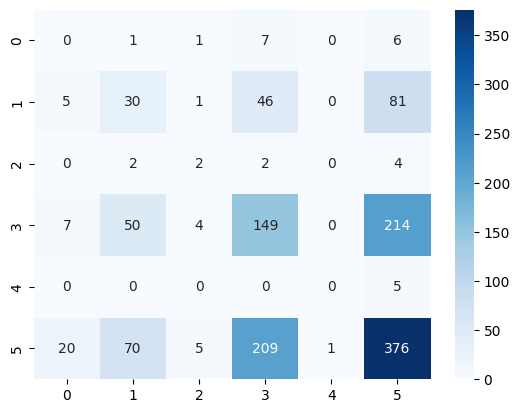

In [129]:
# Confusion Matrix

cf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues');

In [130]:
# Classification Report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.20      0.18      0.19       163
           3       0.15      0.20      0.17        10
           4       0.36      0.35      0.36       424
           5       0.00      0.00      0.00         5
           6       0.55      0.55      0.55       681

    accuracy                           0.43      1298
   macro avg       0.21      0.21      0.21      1298
weighted avg       0.43      0.43      0.43      1298



In [131]:
# Feature Importance

feature_imp = pd.Series(rfc.feature_importances_, index = X.columns).sort_values(ascending = False)
feature_imp

flight_hours_mean                   0.126083
afm_hrs                             0.110839
dprt_time                           0.109497
cert_max_gr_wt                      0.099290
power_units                         0.084806
total_seats                         0.042020
pc_profession                       0.017509
type_last_insp_ANNL                 0.016572
eng_mfgr_LYCOMING                   0.016253
fixed_retractable_RETR              0.015093
eng_mfgr_CONTINENTAL                0.015048
second_pilot                        0.014954
dest_apt_id                         0.014791
acft_make_CESSNA                    0.014311
_PERS                               0.014227
carb_fuel_injection_FINJ            0.014206
carb_fuel_injection_CARB            0.014007
acft_make_infrequent_sklearn        0.013251
eng_mfgr_infrequent_sklearn         0.012328
dprt_apt_id                         0.012283
acft_make_PIPER                     0.011988
type_last_insp_100H                 0.011819
flt_plan_f

In [132]:
# Calculate cumulative sum of feature importance
cumulative_imp = feature_imp.cumsum()

# Identify the cut-off index
cut_off_index = next(x[0] for x in enumerate(cumulative_imp) if x[1] > 0.75)

# Select the important features
important_features = feature_imp.iloc[:cut_off_index]
list(important_features.index)

['flight_hours_mean',
 'afm_hrs',
 'dprt_time',
 'cert_max_gr_wt',
 'power_units',
 'total_seats',
 'pc_profession',
 'type_last_insp_ANNL',
 'eng_mfgr_LYCOMING',
 'fixed_retractable_RETR',
 'eng_mfgr_CONTINENTAL',
 'second_pilot',
 'dest_apt_id',
 'acft_make_CESSNA',
 '_PERS',
 'carb_fuel_injection_FINJ',
 'carb_fuel_injection_CARB']

## Model (RFC)

### Train test split

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

### Process

In [134]:
# Most Frequent Class Accuracy

freq = max(y.value_counts()/len(y))
print("Most Frequent Class Accuracy: %.2f%%" % (freq * 100.0))

Most Frequent Class Accuracy: 52.94%


In [135]:
# Baseline Accuracy

rfc = RandomForestClassifier().fit(X_train, y_train)

y_pred = rfc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Baseline Accuracy: %.2f%%" % (accuracy * 100.0))

Baseline Accuracy: 50.92%


### Performance Analysis

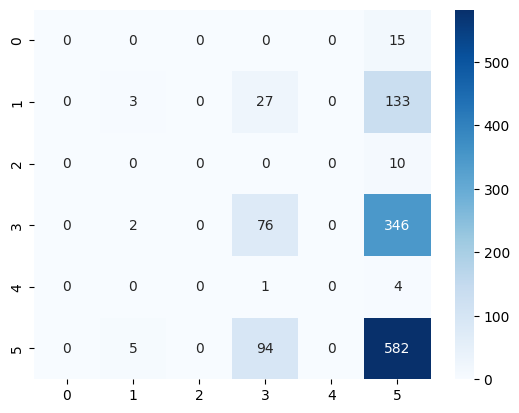

In [136]:
# Confusion Matrix

cf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues');

In [137]:
# Classification Report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.30      0.02      0.03       163
           3       0.00      0.00      0.00        10
           4       0.38      0.18      0.24       424
           5       0.00      0.00      0.00         5
           6       0.53      0.85      0.66       681

    accuracy                           0.51      1298
   macro avg       0.20      0.18      0.16      1298
weighted avg       0.44      0.51      0.43      1298



/home/aaron/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aaron/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aaron/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [138]:
# Feature Importance

feature_imp = pd.Series(rfc.feature_importances_, index = X.columns).sort_values(ascending = False)
feature_imp

flight_hours_mean                   0.123729
afm_hrs                             0.113753
dprt_time                           0.112189
cert_max_gr_wt                      0.098560
power_units                         0.082788
total_seats                         0.042590
pc_profession                       0.017686
eng_mfgr_LYCOMING                   0.017012
type_last_insp_ANNL                 0.015833
dest_apt_id                         0.015126
fixed_retractable_RETR              0.015003
carb_fuel_injection_FINJ            0.014939
eng_mfgr_CONTINENTAL                0.014705
carb_fuel_injection_CARB            0.014618
_PERS                               0.013960
second_pilot                        0.013854
acft_make_infrequent_sklearn        0.013725
acft_make_CESSNA                    0.012817
eng_mfgr_infrequent_sklearn         0.012302
dprt_apt_id                         0.012143
type_last_insp_100H                 0.012023
carb_fuel_injection_UNK             0.011874
acft_make_

In [139]:
# Calculate cumulative sum of feature importance
cumulative_imp = feature_imp.cumsum()

# Identify the cut-off index
cut_off_index = next(x[0] for x in enumerate(cumulative_imp) if x[1] > 0.75)

# Select the important features
important_features = feature_imp.iloc[:cut_off_index]
list(important_features.index)

['flight_hours_mean',
 'afm_hrs',
 'dprt_time',
 'cert_max_gr_wt',
 'power_units',
 'total_seats',
 'pc_profession',
 'eng_mfgr_LYCOMING',
 'type_last_insp_ANNL',
 'dest_apt_id',
 'fixed_retractable_RETR',
 'carb_fuel_injection_FINJ',
 'eng_mfgr_CONTINENTAL',
 'carb_fuel_injection_CARB',
 '_PERS',
 'second_pilot',
 'acft_make_infrequent_sklearn']

## Model (SVC)

### Train test split

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

### Process

In [141]:
# Most Frequent Class Accuracy

freq = max(y.value_counts()/len(y))
print("Most Frequent Class Accuracy: %.2f%%" % (freq * 100.0))

Most Frequent Class Accuracy: 52.94%


In [142]:
# Baseline Accuracy

svc = SVC().fit(X_train, y_train)

y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Baseline Accuracy: %.2f%%" % (accuracy * 100.0))

Baseline Accuracy: 52.31%


### Performance Analysis

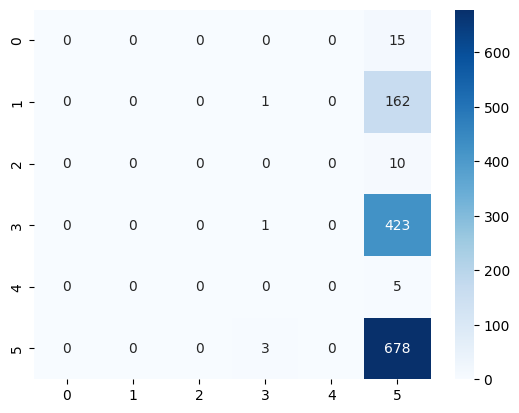

In [143]:
# Confusion Matrix

cf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues');

In [144]:
# Classification Report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00       163
           3       0.00      0.00      0.00        10
           4       0.20      0.00      0.00       424
           5       0.00      0.00      0.00         5
           6       0.52      1.00      0.69       681

    accuracy                           0.52      1298
   macro avg       0.12      0.17      0.12      1298
weighted avg       0.34      0.52      0.36      1298



/home/aaron/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aaron/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aaron/.pyenv/versions/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

## Model (DTC)

### Train test split

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

### Process

In [147]:
# Most Frequent Class Accuracy

freq = max(y.value_counts()/len(y))
print("Most Frequent Class Accuracy: %.2f%%" % (freq * 100.0))

Most Frequent Class Accuracy: 52.94%


In [148]:
# Baseline Accuracy

dtc = DecisionTreeClassifier().fit(X_train, y_train)

y_pred = dtc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Baseline Accuracy: %.2f%%" % (accuracy * 100.0))

Baseline Accuracy: 43.07%


### Performance Analysis

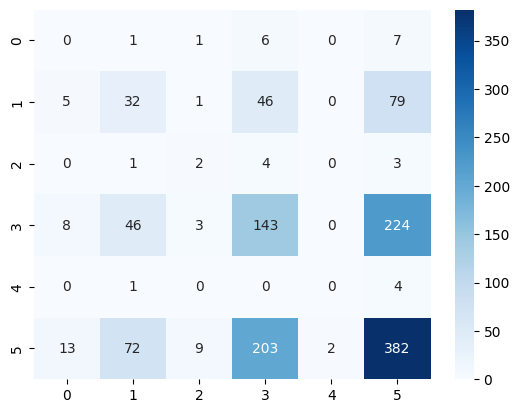

In [149]:
# Confusion Matrix

cf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues');

In [150]:
# Classification Report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.21      0.20      0.20       163
           3       0.12      0.20      0.15        10
           4       0.36      0.34      0.35       424
           5       0.00      0.00      0.00         5
           6       0.55      0.56      0.55       681

    accuracy                           0.43      1298
   macro avg       0.21      0.22      0.21      1298
weighted avg       0.43      0.43      0.43      1298



In [151]:
# Feature Importance

feature_imp = pd.Series(rfc.feature_importances_, index = X.columns).sort_values(ascending = False)
feature_imp

flight_hours_mean                   0.123729
afm_hrs                             0.113753
dprt_time                           0.112189
cert_max_gr_wt                      0.098560
power_units                         0.082788
total_seats                         0.042590
pc_profession                       0.017686
eng_mfgr_LYCOMING                   0.017012
type_last_insp_ANNL                 0.015833
dest_apt_id                         0.015126
fixed_retractable_RETR              0.015003
carb_fuel_injection_FINJ            0.014939
eng_mfgr_CONTINENTAL                0.014705
carb_fuel_injection_CARB            0.014618
_PERS                               0.013960
second_pilot                        0.013854
acft_make_infrequent_sklearn        0.013725
acft_make_CESSNA                    0.012817
eng_mfgr_infrequent_sklearn         0.012302
dprt_apt_id                         0.012143
type_last_insp_100H                 0.012023
carb_fuel_injection_UNK             0.011874
acft_make_

In [152]:
# Calculate cumulative sum of feature importance
cumulative_imp = feature_imp.cumsum()

# Identify the cut-off index
cut_off_index = next(x[0] for x in enumerate(cumulative_imp) if x[1] > 0.75)

# Select the important features
important_features = feature_imp.iloc[:cut_off_index]
list(important_features.index)

['flight_hours_mean',
 'afm_hrs',
 'dprt_time',
 'cert_max_gr_wt',
 'power_units',
 'total_seats',
 'pc_profession',
 'eng_mfgr_LYCOMING',
 'type_last_insp_ANNL',
 'dest_apt_id',
 'fixed_retractable_RETR',
 'carb_fuel_injection_FINJ',
 'eng_mfgr_CONTINENTAL',
 'carb_fuel_injection_CARB',
 '_PERS',
 'second_pilot',
 'acft_make_infrequent_sklearn']

## Model (DNN)

### Train test split

In [105]:
y_cat = to_categorical(y)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.25, random_state=1)

In [107]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3891, 59), (1298, 59), (3891, 7), (1298, 7))

### Process

In [108]:
# Most Frequent Class Accuracy

freq = max(y.value_counts()/len(y))
print("Most Frequent Class Accuracy: %.2f%%" % (freq * 100.0))

Most Frequent Class Accuracy: 52.94%


In [109]:
s_scaler = StandardScaler()
s_scaler.fit(X_train)

X_train = s_scaler.transform(X_train)
X_test = s_scaler.transform(X_test)

In [110]:
def initialize_model():
    
    model = keras.Sequential(
        [
            keras.layers.Dense(256, activation="relu", input_dim=X_train.shape[1]),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(y_train.shape[1], activation='softmax'),
        ]
    )
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy']) 
    
    return model 

dnn = initialize_model()

dnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 256)               15360     
                                                                 
 dense_14 (Dense)            (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 7)                 1799      
                                                                 
Total params: 148,743
Trainable params: 148,743
Non-tr

In [114]:
# Baseline Accuracy

es = EarlyStopping(patience=10, monitor='accuracy')

history = dnn.fit(X_train, y_train, 
                    epochs=100,
                    callbacks=[es], 
                    batch_size=16, 
                    verbose=0)

accuracy = dnn.evaluate(X_test, y_test, verbose=1)[1]
print("Baseline Accuracy: %.2f%%" % (accuracy * 100.0))

41/41 [==============================] - 3s 24ms/step - loss: 5.0070 - accuracy: 0.4515
Baseline Accuracy: 45.15%


### Performance Analysis

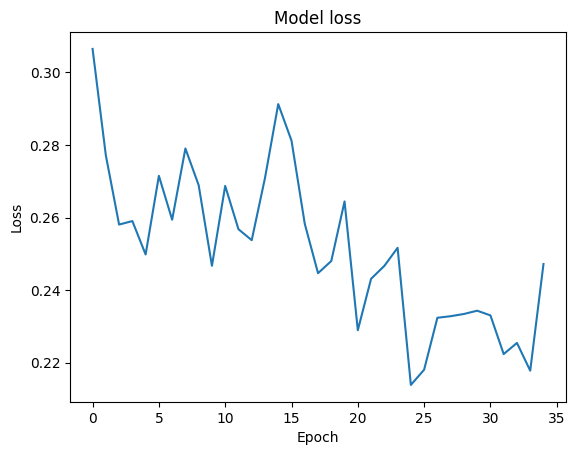

In [115]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_history(history)